train   : 非骨质疏松=751, 骨质疏松=396
test    : 非骨质疏松=95, 骨质疏松=48
val     : 非骨质疏松=95, 骨质疏松=50
extest  : 非骨质疏松=65, 骨质疏松=38

Epoch 1/5


train  : acc=0.7000  auc=0.7033 [0.6716-0.7345]  precision=0.6416  recall=0.2839  specificity=0.9172  f1=0.3936


test   : acc=0.6224  auc=0.6121 [0.5101-0.7036]  precision=0.3636  recall=0.1667  specificity=0.8526  f1=0.2286


val    : acc=0.6667  auc=0.6400 [0.5430-0.7300]  precision=0.5263  recall=0.2041  specificity=0.9053  f1=0.2941


extest : acc=0.7282  auc=0.7579 [0.6598-0.8504]  precision=0.6471  recall=0.5789  specificity=0.8154  f1=0.6111


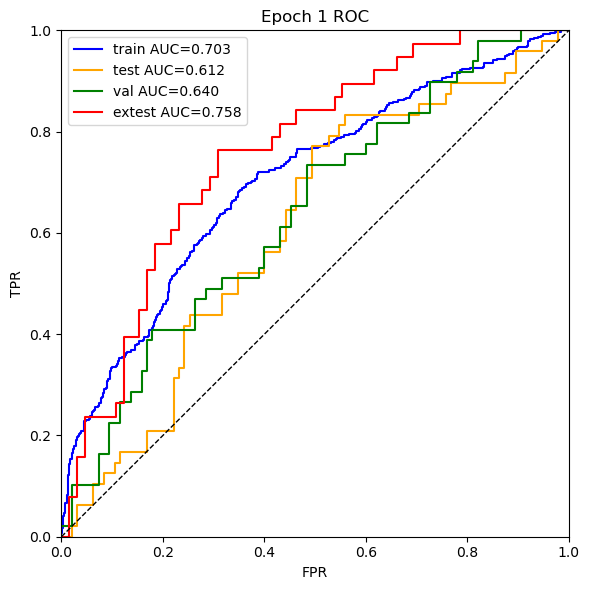


Epoch 2/5


train  : acc=0.7079  auc=0.7511 [0.7217-0.7810]  precision=0.7458  recall=0.2251  specificity=0.9599  f1=0.3458


test   : acc=0.6364  auc=0.5980 [0.5029-0.6916]  precision=0.3889  recall=0.1458  specificity=0.8842  f1=0.2121


val    : acc=0.6667  auc=0.6458 [0.5516-0.7370]  precision=0.5556  recall=0.1020  specificity=0.9579  f1=0.1724


extest : acc=0.6796  auc=0.7283 [0.6309-0.8217]  precision=0.6190  recall=0.3421  specificity=0.8769  f1=0.4407


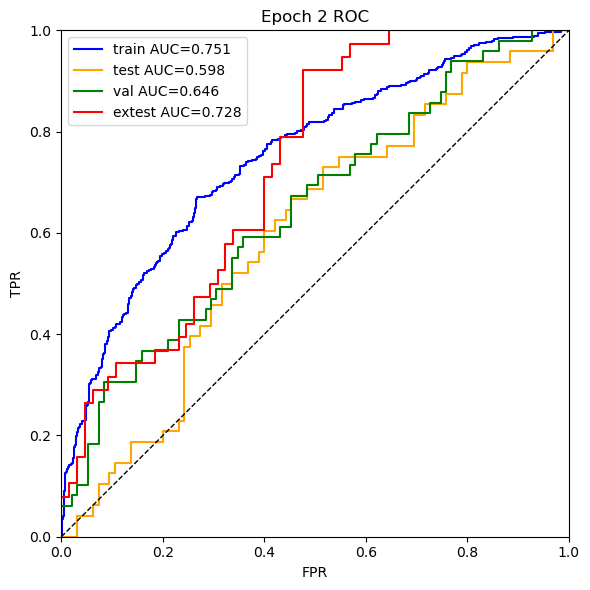


Epoch 3/5


train  : acc=0.7219  auc=0.7950 [0.7665-0.8208]  precision=0.7284  recall=0.3018  specificity=0.9413  f1=0.4268


test   : acc=0.6503  auc=0.6026 [0.5036-0.7000]  precision=0.4444  recall=0.1667  specificity=0.8947  f1=0.2424


val    : acc=0.6806  auc=0.5824 [0.4793-0.6842]  precision=0.6000  recall=0.1837  specificity=0.9368  f1=0.2812


extest : acc=0.7379  auc=0.7968 [0.6996-0.8786]  precision=0.8667  recall=0.3421  specificity=0.9692  f1=0.4906


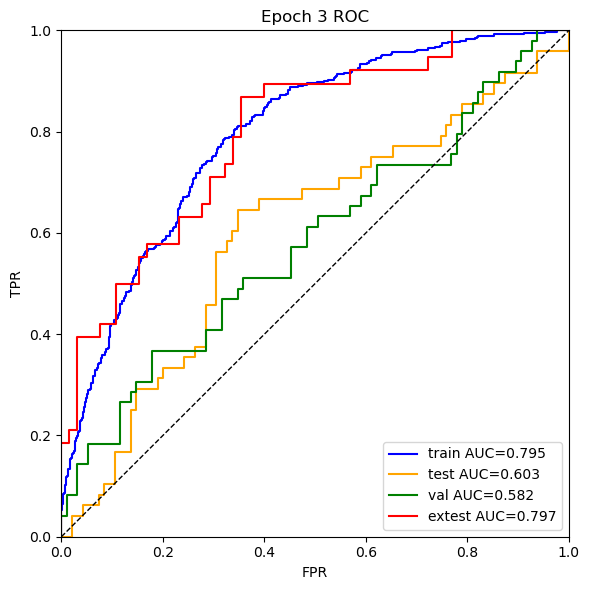


Epoch 4/5


train  : acc=0.7974  auc=0.8685 [0.8477-0.8902]  precision=0.6826  recall=0.7647  specificity=0.8144  f1=0.7214


test   : acc=0.6154  auc=0.6024 [0.5023-0.6973]  precision=0.4386  recall=0.5208  specificity=0.6632  f1=0.4762


val    : acc=0.6181  auc=0.6127 [0.5117-0.7084]  precision=0.4400  recall=0.4490  specificity=0.7053  f1=0.4444


extest : acc=0.7087  auc=0.7146 [0.6063-0.8149]  precision=0.6333  recall=0.5000  specificity=0.8308  f1=0.5588


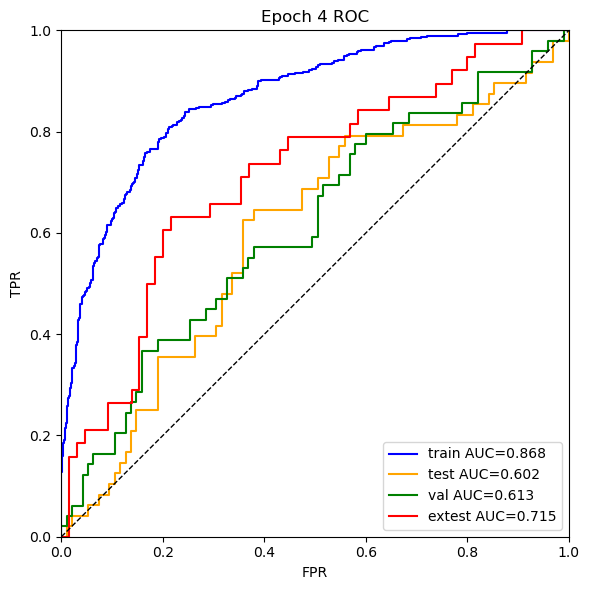


Epoch 5/5


train  : acc=0.8412  auc=0.9173 [0.9005-0.9328]  precision=0.8323  recall=0.6726  specificity=0.9292  f1=0.7440


test   : acc=0.6224  auc=0.6219 [0.5179-0.7168]  precision=0.4318  recall=0.3958  specificity=0.7368  f1=0.4130


val    : acc=0.6667  auc=0.6292 [0.5266-0.7246]  precision=0.5172  recall=0.3061  specificity=0.8526  f1=0.3846


extest : acc=0.6893  auc=0.7437 [0.6397-0.8333]  precision=0.6875  recall=0.2895  specificity=0.9231  f1=0.4074


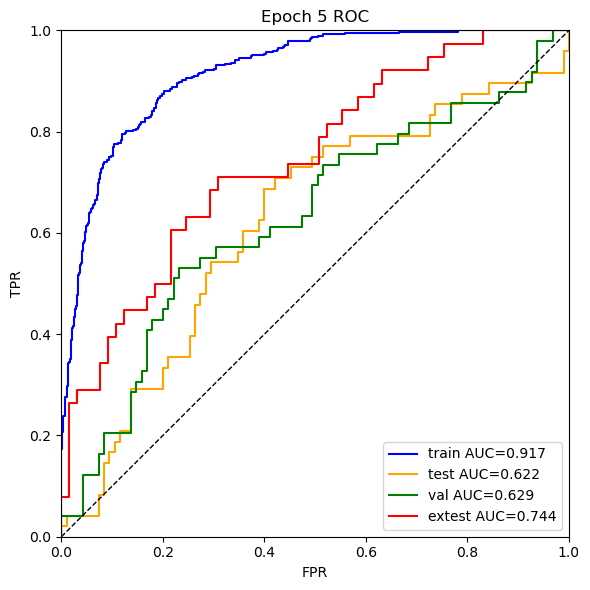


========== 最终平均指标（合并所有样本 + Bootstrap 95% CI） ==========


NameError: name 'ci_up0' is not defined

In [1]:
# run_dual.py
import os, warnings, copy, math, random, time
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix)
from skimage.transform import resize
warnings.filterwarnings('ignore')

# ------------------ Bootstrap AUC 95% CI ------------------
def bootstrap_auc_ci(y_true, y_score, n_boot=2000, ci=0.95, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    aucs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except ValueError:
            continue
    aucs = np.array(aucs)
    auc = roc_auc_score(y_true, y_score)
    lower, upper = np.percentile(aucs, [(1-ci)/2*100, (1+ci)/2*100])
    return auc, lower, upper

# ========== 全局 ==========
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT_DIR = r'D:/骨密度数据集'
TABLES   = ['train_table.xlsx', 'test_table.xlsx', 'val_table.xlsx', 'extest_table.xlsx']
PHASES   = ['train', 'test', 'val', 'extest']
NII_NAMES= ['zw.nii', 'cw.nii']        # 0: 正位  1: 侧位
SEED     = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# 1. 读取 Excel & 统计
stats = {}
dfs   = {}
for tbl, phase in zip(TABLES, PHASES):
    df = pd.read_excel(os.path.join(ROOT_DIR, tbl))
    df['phase'] = phase
    dfs[phase] = df
    pos = df['是否骨质疏松'].sum()
    neg = len(df) - pos
    stats[phase] = (neg, pos)
    print(f'{phase:<8}: 非骨质疏松={neg}, 骨质疏松={pos}')

# 2. Dataset（返回两个模态，分开）
class BMDDualDataset(Dataset):
    def __init__(self, df, max_slices=16, target_shape=(224, 224)):
        self.records = df.to_dict('records')
        self.max_slices, self.target_shape = max_slices, target_shape

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec  = self.records[idx]
        pid  = str(rec['ID'])
        phase= rec['phase']
        vols = []
        for mod in NII_NAMES:
            path = os.path.join(ROOT_DIR, phase, pid, mod)
            if not os.path.isfile(path):
                return None
            try:
                vol = nib.load(path).get_fdata().astype(np.float32)
            except Exception:
                return None
            vol = resize(vol, self.target_shape + (vol.shape[2],),
                         mode='constant', preserve_range=True)
            vol = (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)
            vols.append(vol)

        D = vols[0].shape[2]
        for v in vols:
            if v.shape[2] != D:
                return None
        if D > self.max_slices:
            start = (D - self.max_slices)//2
            vols  = [v[..., start:start+self.max_slices] for v in vols]
        else:
            pad   = self.max_slices - D
            vols  = [np.pad(v, ((0,0),(0,0),(0,pad)), mode='constant') for v in vols]

        # 两个模态分别归一化到 0-1 后，各自作为单通道输入
        ap_img = torch.from_numpy(vols[0]).unsqueeze(0).float()   # (1, H, W, S)
        lat_img= torch.from_numpy(vols[1]).unsqueeze(0).float()
        label  = int(rec['是否骨质疏松'])
        return ap_img, lat_img, label, pid

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None, None, None
    ap_imgs, lat_imgs, labels, pids = zip(*batch)
    return torch.stack(ap_imgs), torch.stack(lat_imgs), torch.tensor(labels), pids

BATCH = 4
loaders = {p: DataLoader(BMDDualDataset(dfs[p]), batch_size=BATCH,
                         shuffle=(p=='train'), num_workers=0,
                         collate_fn=collate_fn) for p in PHASES}

# 3. 双模型
class DualResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 正位分支
        self.ap_net = resnet18(weights='IMAGENET1K_V1')
        self.ap_net.fc = nn.Identity()
        # 侧位分支
        self.lat_net = resnet18(weights='IMAGENET1K_V1')
        self.lat_net.fc = nn.Identity()

        self.classifier = nn.Linear(512*2, 1)

    def forward(self, ap, lat):
        # ap: (B, 1, H, W, S)   lat: (B, 1, H, W, S)
        B, C, H, W, S = ap.shape
        # 把 slice 维度和 batch 维度合并，形成 2D ResNet 输入
        ap = ap.permute(0, 4, 1, 2, 3).reshape(B*S, 1, H, W).repeat(1, 3, 1, 1)
        lat= lat.permute(0, 4, 1, 2, 3).reshape(B*S, 1, H, W).repeat(1, 3, 1, 1)

        f_ap  = self.ap_net(ap).view(B, S, -1).mean(dim=1)   # (B,512)
        f_lat = self.lat_net(lat).view(B, S, -1).mean(dim=1)
        fused = torch.cat([f_ap, f_lat], dim=1)
        return self.classifier(fused).squeeze(1)

model = DualResNet().to(DEVICE)

# 4. 训练配置
LR, EPOCHS = 1e-4, 5
criterion  = nn.BCEWithLogitsLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def metrics(y_true, y_score):
    y_pred = (y_score > 0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn/(tn+fp+1e-8)
    try:
        auc = roc_auc_score(y_true, y_score)
    except:
        auc = np.nan
    return dict(acc=acc, auc=auc, precision=prec,
                specificity=spec, recall=rec, f1=f1)

@torch.no_grad()
def evaluate(phase, collect=False):
    model.eval()
    all_labels, all_scores = [], []
    for ap, lat, labels, _ in tqdm(loaders[phase], desc=phase, leave=False):
        if ap is None:
            continue
        ap, lat, labels = ap.to(DEVICE), lat.to(DEVICE), labels.float().to(DEVICE)
        logits = model(ap, lat)
        scores = torch.sigmoid(logits).cpu().numpy()
        all_scores.append(scores)
        all_labels.append(labels.cpu().numpy())
    if len(all_labels) == 0:
        return None, None, None
    y_true  = np.concatenate(all_labels).astype(int)
    y_score = np.concatenate(all_scores)
    m = metrics(y_true, y_score)
    m['auc'], m['auc_lower'], m['auc_upper'] = bootstrap_auc_ci(y_true, y_score)
    if collect:
        m['y_true']  = y_true
        m['y_score'] = y_score
    return m, y_true, y_score

# 5. 训练循环
history = {p: [] for p in PHASES}
best_auc = 0.
colors = ['blue', 'orange', 'green', 'red']

for epoch in range(1, EPOCHS + 1):
    print(f'\nEpoch {epoch}/{EPOCHS}')
    # ---------- train ----------
    model.train()
    running_loss = 0.
    for ap, lat, labels, _ in tqdm(loaders['train'], desc='train', leave=False):
        if ap is None:
            continue
        ap, lat, labels = ap.to(DEVICE), lat.to(DEVICE), labels.float().to(DEVICE)
        logits = model(ap, lat)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ap.size(0)
    scheduler.step()

    # ---------- 评估 ----------
    fig, ax = plt.subplots(figsize=(6, 6))
    for phase, color in zip(PHASES, colors):
        m, y_true, y_score = evaluate(phase)
        if m is None:
            continue
        history[phase].append(m)
        print(f'{phase:<7}: '
              f'acc={m["acc"]:.4f}  '
              f'auc={m["auc"]:.4f} [{m["auc_lower"]:.4f}-{m["auc_upper"]:.4f}]  '
              f'precision={m["precision"]:.4f}  '
              f'recall={m["recall"]:.4f}  '
              f'specificity={m["specificity"]:.4f}  '
              f'f1={m["f1"]:.4f}')
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, color=color, label=f'{phase} AUC={m["auc"]:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
    ax.set_title(f'Epoch {epoch} ROC'); ax.legend()
    plt.tight_layout(); plt.show(block=False); plt.pause(1); plt.close(fig)

    # ---------- 保存 best ----------
    val_ext = [h['auc'] for h in history['val'] + history['extest'] if h]
    if val_ext and np.nanmean(val_ext) > best_auc:
        best_auc = np.nanmean(val_ext)
        torch.save(model.state_dict(), 'best.pth')

# 6. 最终平均指标
print('\n========== 最终平均指标（合并所有样本 + Bootstrap 95% CI） ==========')
ax.clear()
model.load_state_dict(torch.load('best.pth', map_location=DEVICE))

for phase, color in zip(PHASES, colors):
    m, y_true, y_score = evaluate(phase, collect=True)
    if m is None:
        continue
    ci_auc, ci_low, ci_up = m['auc'], m['auc_lower'], m['auc_upper']
    print(f'{phase:<7}: '
          f'acc={m["acc"]:.4f}  '
          f'auc={ci_auc:.4f} [{ci_low:.4f}-{ci_up0:.4f}]  '
          f'precision={m["precision"]:.4f}  '
          f'recall={m["recall"]:.4f}  '
          f'specificity={m["specificity"]:.4f}  '
          f'f1={m["f1"]:.4f}')
    fpr, tpr, _ = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr, color=color,
            label=f'{phase} AUC={ci_auc:.3f} [{ci_low:.3f}-{ci_up:.3f}]')

ax.plot([0,1],[0,1],'k--'); ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.legend(); ax.set_title('Final ROC with Bootstrap 95% CI'); plt.show()

In [2]:
# ==================== 新增代码：分别保存正位/侧位单模态预测 ====================
import os
import pandas as pd
from tqdm import tqdm

# 两个单模态模型
class SingleResNet(nn.Module):
    def __init__(self, view='ap'):
        super().__init__()
        self.backbone = resnet18(weights='IMAGENET1K_V1')
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Linear(512, 1)
        self.view = view.lower()

    def forward(self, x):
        # x: (B, 1, H, W, S)
        B, C, H, W, S = x.shape
        x = x.permute(0, 4, 1, 2, 3).reshape(B * S, 1, H, W).repeat(1, 3, 1, 1)
        feat = self.backbone(x).view(B, S, -1).mean(dim=1)
        return self.classifier(feat).squeeze(1)

# 为每个 view + phase 生成 CSV
def save_single_view_preds(view='ap'):
    model = SingleResNet(view).to(DEVICE)
    # 加载原双模态权重，只保留对应分支的参数
    dual_sd = torch.load('best.pth', map_location=DEVICE)
    single_sd = model.state_dict()
    prefix = {'ap': 'ap_net.', 'lat': 'lat_net.'}[view]
    for k in list(dual_sd.keys()):
        if k.startswith(prefix):
            new_k = k[len(prefix):]
            if new_k in single_sd:
                single_sd[new_k] = dual_sd[k]
    model.load_state_dict(single_sd)
    model.eval()

    for phase in PHASES:
        ids, y_true, y_score = [], [], []
        for imgs, _, labels, pids in tqdm(loaders[phase], desc=f'{view}_{phase}'):
            if imgs is None:
                continue
            imgs = imgs if view == 'ap' else _   # _ 为侧位
            imgs, labels = imgs.to(DEVICE), labels.float().to(DEVICE)
            with torch.no_grad():
                logits = model(imgs)
                scores = torch.sigmoid(logits).cpu().numpy()
            ids.extend(pids)
            y_true.extend(labels.cpu().numpy().astype(int))
            y_score.extend(scores)
        df = pd.DataFrame({
            'ID': ids,
            'true_label': y_true,
            'pred_prob': y_score,
            'pred_label': (np.array(y_score) > 0.5).astype(int)
        })
        fname = f'{view}_{phase}_pred.csv'
        df.to_csv(fname, index=False, encoding='utf-8-sig')
        print(f'Saved {fname}')

# 分别导出正位和侧位结果
save_single_view_preds('ap')
save_single_view_preds('lat')

ap_train: 100%|██████████████████████████████████████████████████████████████████████| 287/287 [17:56<00:00,  3.75s/it]


Saved ap_train_pred.csv


ap_test: 100%|█████████████████████████████████████████████████████████████████████████| 36/36 [02:11<00:00,  3.66s/it]


Saved ap_test_pred.csv


ap_val: 100%|██████████████████████████████████████████████████████████████████████████| 37/37 [02:17<00:00,  3.73s/it]


Saved ap_val_pred.csv


ap_extest: 100%|███████████████████████████████████████████████████████████████████████| 26/26 [00:46<00:00,  1.80s/it]


Saved ap_extest_pred.csv


lat_train: 100%|█████████████████████████████████████████████████████████████████████| 287/287 [18:04<00:00,  3.78s/it]


Saved lat_train_pred.csv


lat_test: 100%|████████████████████████████████████████████████████████████████████████| 36/36 [02:14<00:00,  3.74s/it]


Saved lat_test_pred.csv


lat_val: 100%|█████████████████████████████████████████████████████████████████████████| 37/37 [02:20<00:00,  3.81s/it]


Saved lat_val_pred.csv


lat_extest: 100%|██████████████████████████████████████████████████████████████████████| 26/26 [00:44<00:00,  1.73s/it]

Saved lat_extest_pred.csv
